# Tutorial 6: Iterative Methods and Non-Linear Regression


## Exercise 1: Polynomial Regression


Last tutorial, we saw some examples of Linear Regression, but using the same approach, we can estimate the polynomial of arbitrary degree that minimizes the residuals in the least-squares sense.

Remember from lecture, that the function $y(x)$ can be approximated using the basis functions $\phi_{i}(x)$:

$$\tilde{y}(x) = c_{1}\phi_{1}(x)+\dots+c_{n}\phi_{n}(x)$$

In Polynomial regression, we choose as basis functions the following monomials:

$$\phi_{i}(x) = x^{i}$$

The value of the coefficients $c_{i}$ can be obtained by solving the following system, which identifies the polynomial that minimizes the residuals in the least-squares sense.

$$c=\arg\min_{c}(||Y-\tilde{y}(X)||^{2})=\arg\min_{c}(||Y-\sum_{i=0}^{n} c_{i}\phi_{i}(X)||^{2})=$$

$$
=\arg\min_{c}\left(\left|\left|
\begin{bmatrix}
    y_{0} \\
    y_{1} \\
    \vdots \\
    y_{m}
\end{bmatrix}
-
\begin{bmatrix}
    1       & x_{0}   & \dots   & x_{0}^{n} \\
    1       & x_{1}   & \dots   & x_{1}^{n} \\
    \vdots  & \vdots  & \ddots  & \vdots \\
    1       & x_{m}   & \dots   & x_{m}^{n} \\
\end{bmatrix}
\begin{bmatrix}
    c_{0} \\
    c_{1} \\
    \vdots \\
    c_{n}
\end{bmatrix}
\right|\right|^{2}\right)=
$$

$$=\arg\min_{c}(||Y-A(X)c||^{2})$$

$$c=(A^{T}A)^{-1}A^{T}Y = A^{\dagger}Y$$


Let's consider the following set of points:

|  x  |  y   |
| :-: | :--: |
| -2  | 3.64 |
| -1  | 2.40 |
|  0  | 1.55 |
|  1  | 1.13 |
|  2  | 1.07 |

These were extracted from the curve $y(x) = \frac{1}{5}x^{2}-\frac{2}{3}x+\frac{3}{2}$, but the measurements were affected by an additional Gaussian zero-mean noise.
Let's try to find the regression quadratic function that best fits these numbers.


In [ ]:
import LinearAlgebra as linalg
using LinearAlgebra

# Define the nodes
X = [-2.0; -1.0; 0.0; 1.0; 2.0]; # x coordinates of the nodes
Y = [3.64; 2.40; 1.55; 1.13; 1.07]; # y coordinates of the nodes
n = length(X)

# Define the matrix A for a 2nd degree regression
A = [linalg.ones(n) X X.^2]; #5x3 (m x (n+1))

# Find the coefficients
c = inv(A'*A)*A'*Y;
println("Approximated function:")
println("\ty = $(round(c[3],digits=3))x^2+$(round(c[2],digits=3))x+$(round(c[1],digits=3))")

# Compute the residuals
p2(x) = @. c[3]*x^2+c[2]*x+c[1];
res2 = linalg.norm(p2(X)-Y)^2
println("The squared residual for the quadratic regression is $res2.")

Approximated function:
	y = 0.199x^2+-0.641x+1.559
The squared residual for the quadratic regression is 0.0002628571428571391.


But since we have 5 points, we can also try a cubic and quartic regression.
For a quartic polynomial, the matrix A would be square, and we would obtain a Polynomial Interpolation since we can choose a set of coefficients that would set the residuals to zero.


In [3]:
# Define the matrix A for a 3rd degree regression
A = [linalg.ones(n) X X.^2 X.^3];

# Find the coefficients
c = inv(A'*A)*A'*Y;
println("Approximated function:")
println("\ty = $(round(c[4],digits=3))x^3+$(round(c[3],digits=3))x^2+$(round(c[2],digits=3))x+$(round(c[1],digits=3))")

# Compute the residuals
p3(x) = @. c[4]*x^3+c[3]*x^2+c[2]*x+c[1];
res3 = linalg.norm(p3(X)-Y)^2
println("The squared residual for the quartic regression is $res3.")

Approximated function:
	y = -0.002x^3+0.199x^2+-0.633x+1.559
The squared residual for the quartic regression is 0.00017285714285713896.


In [4]:
# Define the matrix A for a 4th degree regression
A = [linalg.ones(n) X X.^2 X.^3 X.^4];

# Find the coefficients
c = inv(A'*A)*A'*Y;
println("Approximated function:")
println("\ty = $(round(c[5],digits=3))x^4+$(round(c[4],digits=3))x^3+$(round(c[3],digits=3))x^2+$(round(c[2],digits=3))x+$(round(c[1],digits=3))")

# Compute the residuals
p4(x) = @. c[5]*x^4+c[4]*x^3+c[3]*x^2+c[2]*x+c[1];
res4 = linalg.norm(p4(X)-Y)^2
println("The squared residual for the quartic regression is $res4.")

Approximated function:
	y = -0.005x^4+-0.002x^3+0.22x^2+-0.633x+1.55
The squared residual for the quartic regression is 8.838200366869913e-28.


As expected, the residual for the quartic polynomial is close to zero, since the polynomial can always pass through each of the given points (as long as they don't have the same x value).


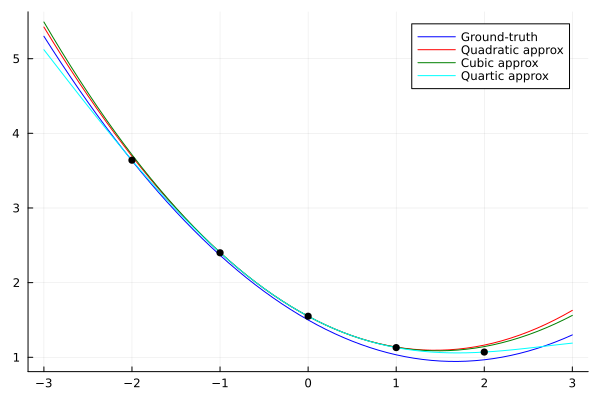

In [5]:
import Plots as plt

# Ground-truth function
p(x) = @. 1/5*x^2-2/3*x+3/2;
x = -3:0.10:3;

# Plot
plt.plot(x,p(x),label="Ground-truth",color=:blue)
plt.plot!(x,p2(x),label="Quadratic approx",color=:red)
plt.plot!(x,p3(x),label="Cubic approx",color=:green)
plt.plot!(x,p4(x),label="Quartic approx",color=:cyan)
plt.scatter!(X,Y,label="",color=:black)

## Exercise 2: Gauss-Seidel Method


Let's consider the **Gauss-Seidel** method to approximate the solution of a linear system.

$$A = L_{A}+D_{A}+U_{A}$$
$$x^{(k)} = (L_{A}+D_{A})^{-1}(b-U_{A}x^{(k-1)})$$

which can be implemented in Julia as follows:


In [ ]:
"""
Solve Ax=b iteratively using the Gauss-Seidel method with initial iteration x0. 

Inputs:
    A: nxn real matrix 
    b: n-element real vector
    x0: initial iteration
    k_max: maximum number of iterations
    res_tol: residual error tolerance criterion; terminate once norm(A*x - b) <= res_tol
Outputs:
    x: n-element real vector containing the solution returned by the Jacobi method
    x_his: nxk matrix of the history of x, containing the solution returned by the 
            Jacobi method at each iteration.
"""
function gauss_seidel(A, b, x0, k_max, res_tol)
    M = linalg.tril(A)
    N = -linalg.triu(A, 1)
    x = copy(x0)
    x_his = []
    for k in 1:k_max
        x = forward_substitution(M, b + N*x)
        push!(x_his,x)
        if linalg.norm(A*x - b) <= res_tol
            break
        end
    end
    return x, x_his
end

# Add definition of forward_substitution function
include("library.jl") # Add your own formulation

gaussian_elimination

As for Jacobi, this method also has a convergence theorem:
$$G=-(L_{A}+D_{A})^{-1}U_{A}$$
$$e^{(k)} = G\cdot e^{(k-1)} = G^{k}\cdot e^{(0)}$$
$$||e^{(k)}|| \leq ||G||^{k}\cdot||e^{(0)}||$$
So we define again a function to compute the error bound at each iteration:


In [7]:
"""
Return the upper error bound for the Gauss-Seidel method on matrix A with initial iteration x0. 

Inputs:
    A: nxn real matrix 
    k_max: number of iterations
    x0: initial iteration
    x_true: ground-truth value used to compute output errors 
Outputs:
    bounds: upper bound on errs computed using the convergence theory discussed in lecture. 
"""
function gauss_seidel_bound(A, k_max, x0, x_true)
    M = linalg.tril(A)
    N = -linalg.triu(A, 1)
    G = linalg.zeros(size(A))
    for k in 1:size(A, 2)
        G[:, k] = forward_substitution(M, N[:, k])
    end
    α_err = linalg.opnorm(G,2)
    println("The 2-norm of G is $α_err.") 
    
    bounds = zeros(k_max + 1)
    bounds[1] = linalg.norm(x0 - x_true)
    for k in 1:k_max
        bounds[k+1] = α_err * bounds[k]
    end
    return bounds
end

gauss_seidel_bound

Let's test empirically if the convergence theorem is satisfied by the Gauss-Seidel method:


In [8]:
import Random as rnd
rnd.seed!(2025)

# Define linear system
n = 100
A = rnd.rand(n,n)+n*linalg.I(n)
b = rnd.rand(n)

# Find ground-truth solution
x_true = BigFloat.(A) \ BigFloat.(b);

# Apply Gauss-Seidel method
x0 = linalg.ones(n);
x_gs, x_his = gauss_seidel(A, b, x0, 100, 1e-6);
k = length(x_his);
println("The Gauss-Seidel method stopped after $k iterations.")

# Compute empirical error
err_emp = linalg.zeros(k+1);
err_emp[1] = linalg.norm(x0-x_true)
for ii in 1:k
    err_emp[ii+1] = linalg.norm(x_his[ii]-x_true);
end

# Compute theoretical upper bound
err_theo = gauss_seidel_bound(A, k, x0, x_true);

The Gauss-Seidel method stopped after 10 iterations.
The 2-norm of G is 0.2714829052440506.


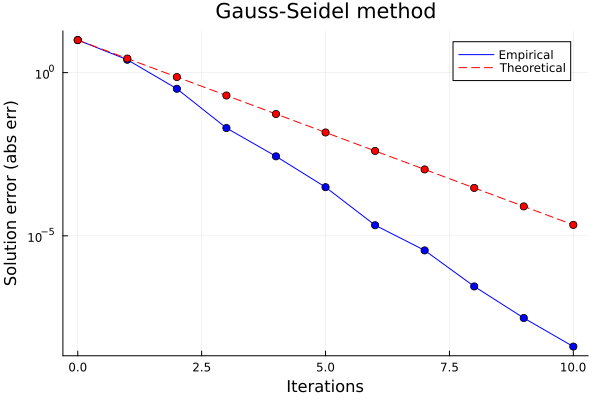

In [9]:
plt.plot(0:k,err_emp,color=:blue,label="Empirical",yscale=:log10)
plt.scatter!(0:k,err_emp,color=:blue,label="")
plt.plot!(0:k,err_theo,color=:red,label="Theoretical",ls=:dash)
plt.scatter!(0:k,err_theo,color=:red,label="")
plt.title!("Gauss-Seidel method")
plt.xlabel!("Iterations")
plt.ylabel!("Solution error (abs err)")

As before, the convergence is also not guaranteed in the generic case for Gauss-Seidel method.


In [10]:
# Define linear system
n = 3
A = rnd.randn(n,n)
b = rnd.randn(n)

# Find ground-truth solution
x_true = BigFloat.(A) \ BigFloat.(b);

# Apply Jacobi method
x0 = linalg.ones(n);
x_j, x_his = gauss_seidel(A, b, x0, 10, 1e-6);
k = length(x_his);
println("The Gauss-Seidel method stopped after $k iterations.")

# Compute empirical error
err_emp = linalg.zeros(k+1);
err_emp[1] = linalg.norm(x0-x_true)
for ii in 1:k
    err_emp[ii+1] = linalg.norm(x_his[ii]-x_true);
end

# Compute theoretical upper bound
err_theo = gauss_seidel_bound(A, k, x0, x_true);

# Print final error value
println("The empirical error in the last iteration of Gauss-Seidel was $(err_emp[end]).")
println("The theoretical error upper bound in the last iteration of Gauss-Seidel was $(err_theo[end]).")

The Gauss-Seidel method stopped after 10 iterations.
The 2-norm of G is 47.3824088020803.
The empirical error in the last iteration of Gauss-Seidel was 7.666002630726011e15.
The theoretical error upper bound in the last iteration of Gauss-Seidel was 6.668501568939932e16.


## Exercise 3: Computational Time of Gauss-Seidel


We have seen that the Gauss-Seidel method is able to solve linear systems where the matrix is _diagonally-dominant_.
But how does it perform compared to other linear systems solving strategies?

Let's compare the Gauss-Seidel method's accuracy and computational time with Gaussian Elimination and the default solver for Julia.


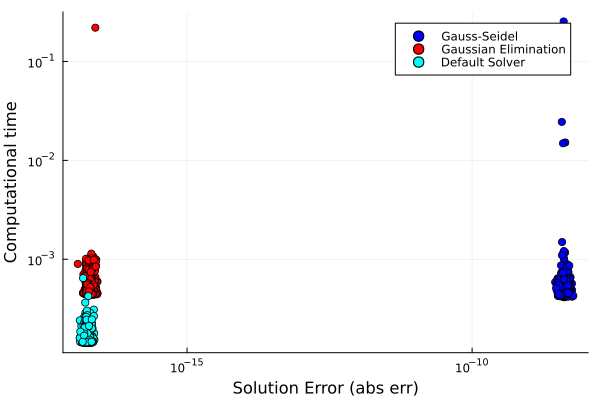

In [11]:
# Initialize arrays
n = 100
N = 500
rnd.seed!(2025)

timeGS = zeros(N)
timeGE = zeros(N)
timeDS = zeros(N)
errGS = zeros(N)
errGE = zeros(N)
errDS = zeros(N)

# Add definition of Gaussian Elimination function
include("library.jl")

# Solve the linear system N times
for ii = 1:N
    # Generate linear system
    A = rnd.rand(n,n)+n*linalg.I(n)
    b = rnd.rand(n)

    # Get ground-truth solution
    ABig = BigFloat.(A)
    bBig = BigFloat.(b)
    xBig = ABig \ bBig

    # Solve with Gauss-Seidel
    x0 = linalg.ones(n)
    xGS, timeTempGS = @timed gauss_seidel(A, b, x0, 100, 1e-6)
    xGS = xGS[1]
    errGS[ii] = linalg.norm(xGS - xBig)
    timeGS[ii] = timeTempGS

    # Solve with Gaussian Elimination
    xGE, timeTempGE = @timed gaussian_elimination(A, b)
    errGE[ii] = linalg.norm(xGE - xBig)
    timeGE[ii] = timeTempGE

    # Solve with Default Solver (LU factorization with partial pivoting)
    xDS, timeTempDS = @timed A \ b
    errDS[ii] = linalg.norm(xDS - xBig)
    timeDS[ii] = timeTempDS
end

# Make scatterplot of solution error vs computational time
plt.scatter(errGS,timeGS,color=:blue,label="Gauss-Seidel",xscale=:log10,yscale=:log10)
plt.scatter!(errGE,timeGE,color=:red,label="Gaussian Elimination")
plt.scatter!(errDS,timeDS,color=:cyan,label="Default Solver")
plt.xlabel!("Solution Error (abs err)")
plt.ylabel!("Computational time")

In [12]:
mean(x) = sum(x)/length(x)
println("Gauss-Seidel method: \t\ttime = $(round(mean(timeGS),sigdigits=5))s, \tabs error = $(round(mean(errGS),sigdigits=5))")
println("Gaussian Elimination method: \ttime = $(round(mean(timeGE),sigdigits=5))s, \tabs error = $(round(mean(errGE),sigdigits=5))")
println("Default Solver method: \t\ttime = $(round(mean(timeDS),sigdigits=5))s, \tabs error = $(round(mean(errDS),sigdigits=5))")

Gauss-Seidel method: 		time = 0.0011406s, 	abs error = 4.2308e-9
Gaussian Elimination method: 	time = 0.00099864s, 	abs error = 2.0494e-17
Default Solver method: 		time = 0.00017158s, 	abs error = 1.7918e-17
